# **Projekt Modelowanie Układów Przepływowych**
## **Jak wpływa pogłebianie dna na wysokość oraz prędkość rejestrowanych fal?**
### 25.11.2025
### Daria Klimaszewska

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')
    !pip install --quiet pint

Zadaniem projektu było zrobienie symulacji z użyciem solvera równań płytkiej wody o wybranych parametrach w celu odpowiedzi na wybrane przez siebie pytanie. W pierwszej kolejności zaimportowano potrzebne pakiety Pythona oraz zmieniono backend numby na OpenMP, aby pakiet PyMPDATA był kompatybilny ze środowiskiem Google Colab.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
import numba
from pint import UnitRegistry, Quantity
from matplotlib.ticker import FuncFormatter
numba.config.THREADING_LAYER="omp"
si = UnitRegistry()

### Używane symbole
W projekcie używam wartości zdefiniowanych podczas wykładu czyli:


*   b (*bathymetry* w kodzie)  oznacza odległość do dna od punktu odniesienia (z=0)
* $\zeta$ (*zeta*  w kodzie) oznacza odległość do powierzchni wody od punktu odniesienia (z=0)
*   h (*h* w kodzie) oznacza sumaryczną odległość od dnia do powierzchni wody

Przedstawione są one na poniższym wykresie. W tym projekcie modyfikowany będzie kształt dna, a zatem definiowane będzie autorskie *bathymetry*.

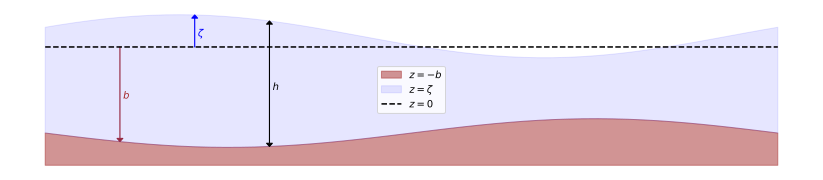

In [ ]:
plt.figure(figsize=(14.5,3))
plt.axis('off')

x = np.linspace(-np.pi, np.pi)
z = np.cos(x+2)/2+.25
b = np.sin(x)/3-2

arrow_kwargs = {'length_includes_head': True, 'head_width': .05}

ix = 5; color='brown'; label='$b$'
plt.fill_between(x, b, -2.75, color=color, label=f'$z=-${label}', alpha=.5)
plt.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
plt.annotate(f" {label}", xy=(x[ix], b[ix] + 1), color=color)

ix = 10; color='blue'; label=r'$\zeta$'
plt.fill_between(x, z, b, color=color, label=f'$z=${label}', alpha=.1)
plt.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
plt.annotate(f" {label}", xy=(x[ix], z[ix] - .5), color=color)

ix = 15; color='black'; label='$h$'
plt.plot(x, np.full_like(x, 0), linestyle='--', color=color, label='$z=0$')
plt.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
plt.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
plt.annotate(f" {label}", xy=(x[ix], -1), color=color)

plt.legend(loc=10)
show_plot('symbols')

## Założenia projektu
Zadaniem projektu jest zbadanie wpływu zmiany kształtu dna na wysokość oraz prędkość rejestrowanych fal. Wybrany kształt dnia ma odwierciedlać jego kształt po procesie powiększania plaży polegającym na przeniesieniu piasku na brzeg  z dna akwenu w pewnej odległości niego. Pozostawia to charakterystyczny kształt powierzchni piasku polegający na (idąc od brzegu) powolnym i stałym zwiększaniu głebokości, a następnie nagły wzrost głebokości (pozostały po wydobyciu piasku). Kształt takiego dna widoczny jest na wykresie poniżej. Dodatkowo zaznaczone są dwa  parametry, które będą zmieniane celem określenia ich wpływu na wysokość i prędkość fal. Pierwszy z nich oznacza maksymalną głebokość dna (*bottom_level*), a drugi oznacza współrzędną na osi Z na której kończy się "schodek" w dnie (*plateau_level*), a zaczyna jego łagodne unoszenie ku brzegowi.

Poniżej zdefiniowana jest funkcja zwracająca powierzchnię *bathymetry*. Przyjmuje ona dwa argumenty wspomniane powyżej oraz siatkę, na której będą prowadzone obliczenia. Zakładane jest, że w 1/3 długości siatki  w osi Y ($y_0$)przyłożony będzie schodek bazowany na eksponencjalnej funkcji:
$$z=bottom\_level +(plateau\_level  - bottom\_level) \frac{1}{1+e^{0.6\cdot(y-y_0)}}$$
Następnie przyłączany jest do niego odcinek pochylonej płaszczyzny o równaniu(gdzie $y_{max}$ to długość siatki):
$$z = (1-plateau\_level)\frac{y-y_0}{y_{max}-y_0}$$

Zakładam stałą głebokość z przedziało (0m,10m), którą przeskalowuje do przedziału z zakresu (0,1).

/tmp/ipython-input-1570273592.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


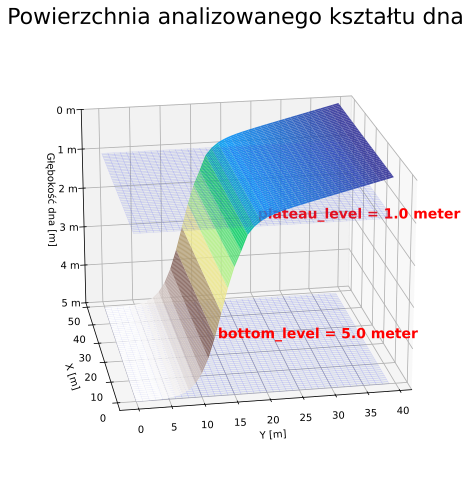

In [ ]:
grid = (50, 40)
def create_bathymetry(grid:np.ndarray, plateau_level:Quantity, bottom_level:Quantity, si:UnitRegistry):
  y_coords = np.arange(grid[1])
  z_scale = 10*si.m
  step_end_fraction = 1/3  # gdzie zaczyna się schodek
  step_end_y = int(grid[1] * step_end_fraction)

  plateau_level = ((z_scale-plateau_level)/z_scale).magnitude #gdzie kończy się schodek i zaczyna wypłaszczenie
  assert type(plateau_level)==float
  transition_steepness = 0.6

  transition = 1 / (1 + np.exp(-transition_steepness * (y_coords - step_end_y)))

  bottom_level = ((z_scale-bottom_level)/z_scale).magnitude
  assert type(bottom_level)==float
  top_level = (10*si.m/z_scale).magnitude
  assert type(top_level)==float

  step_part = bottom_level + (plateau_level - bottom_level) * transition

  slope = np.where(transition > plateau_level,
                  (top_level - plateau_level) * (y_coords - step_end_y) / (grid[1] - step_end_y),
                  0)
  ones = np.ones(grid)

  bathymetry = ones - np.tile(step_part + slope, (grid[0], 1))

  return bathymetry


bathymetry =create_bathymetry(grid, plateau_level=1*si.m, bottom_level=5*si.m, si=si)
##ploting###
x = np.arange(grid[0])
y = np.arange(grid[1])

X, Y = np.meshgrid(y, x)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
z_plane = 0.1  # wybrana wysokość

X_plane, Y_plane = np.meshgrid(np.arange(grid[1]), np.arange(grid[0]))
Z_plane = np.full_like(X_plane, z_plane, dtype=float)


ax.plot_surface(X_plane, Y_plane, Z_plane,
                alpha=0.1,
                color='lightblue',
                edgecolor='blue',
                linewidth=0.5)


ax.text(6*grid[1]//7, grid[0]//50, z_plane,
        f'plateau_level = {abs(z_plane*10*si.m)}',
        color='red',
        fontsize=14,
        fontweight='bold',
        ha='center')
z_plane = 0.5  # wybrana wysokość

X_plane, Y_plane = np.meshgrid(np.arange(grid[1]), np.arange(grid[0]))
Z_plane = np.full_like(X_plane, z_plane, dtype=float)


ax.plot_surface(X_plane, Y_plane, Z_plane,
                alpha=0.1,
                color='lightblue',
                edgecolor='blue',
                linewidth=0.5)

ax.text(4*grid[1]//5, grid[0]//2, z_plane,
        f'bottom_level = {abs(z_plane*10*si.m)}',
        color='red',
        fontsize=14,
        fontweight='bold',
        ha='center')
surf = ax.plot_surface(X, Y, bathymetry, cmap='terrain', edgecolor='none', alpha=0.9)
z_ticks = ax.get_zticks()
ax.set_zticks(z_ticks)
ax.set_zlim(z_ticks[1], z_ticks[-2])
ax.set_zticklabels([f'{tick*10:.0f} m' for tick in z_ticks])
ax.invert_zaxis()
ax.set_xlabel('Y [m]')
ax.set_ylabel('X [m]')
ax.set_zlabel('Głębokość dna [m]')
ax.set_title('Powierzchnia analizowanego kształtu dna', fontsize=22)
ax.view_init(elev=20, azim=260)

plt.tight_layout()
show_plot('bathymetry')


###  Solwer "hello-world" zbudowany na bazie PyMPDATA

In [ ]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray,bathymetry:np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        self.bathymetry = bathymetry
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

## Przebieg symulacji
Definiuję funkcję, która przyjmując jako argument współrzędną najgłebszego momentu dna i współrzędną końca "schodka" oraz rozmiar siatki, i rozdzielczość czasową wywołuje symulacje z użyciem powyższego solwera. Siatkę definiuję jako płaszczyznę XY o wymiarach domyślnych 50m w osi X i 40m w osi Y. Jako warunek początkowy jest zakładane zaburzenie o kształcie prostokąta o wymiarach (5m,4m) umieszczone przy granicy domeny y=0m w połowie osi X.
Dodatkowo zakładam kroki przestrzenne dx=1m, dy=1m.
Krok czasowy zakładam jako dt=0.25s



In [ ]:
X = 50*si.m
Y = 40*si.m
time  = 25*si.s
outfreq = 3
dx = 1*si.m
dy = 1*si.m
dt = 0.25*si.s
nt=int((time/dt).to_base_units().magnitude)
dt_dx = (dt/dx).to_base_units().magnitude
dt_dy = (dt/dy).to_base_units().magnitude
def solve(bottom:float, plateau:float, grid = (X.magnitude, Y.magnitude), dt_dxy = (.25, .25), nt=nt, units=si, outfreq = 3):
  bathymetry = create_bathymetry(grid, plateau_level=plateau, bottom_level=bottom,si=si )
  zeta = np.zeros(grid, dtype=float)
  zeta[
      grid[0] // 2 - grid[0] // 20:
      grid[0] // 2 + grid[0] // 20,
      grid[1] // 20 - grid[1] // 20:
      grid[1] // 20 + grid[1] // 20
  ] += .025
  h_initial = bathymetry + zeta

  output = ShallowWaterEquationsIntegrator(
      h_initial=h_initial, bathymetry=bathymetry
  )(
      nt=nt, g=10, dt_over_dxy=dt_dxy, outfreq=outfreq #outfrequency =
  )
  return output, outfreq, bathymetry

### Wizualizacja
Definiuje funkcje pozwalające wyrysować wykres powierzchni wody, oraz powierzchni z nałożonym polem prędkośći, a także funkcję pozwalająca na wyrysowanie animacji z przekroju wody.

In [ ]:

def plot(frame, output, outfreq, dt, dx, dy, ax=None, zlim=(-.25, 0.25)):
    psi = output['h'][frame]
    xi, yi = np.indices(psi.shape)
    xi = (xi + 0.5) * dx.magnitude
    yi = (yi + 0.5) * dy.magnitude

    if ax == None:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    else:
        fig = ax.figure

    ax.plot_wireframe(xi, yi, psi-bathymetry, color='blue', linewidth=.5)
    ax.set(zlim=zlim, proj_type='ortho',
           title=f"t = {frame*outfreq*dt.magnitude:.1f} s",
           zlabel=r"$\zeta$")

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)

    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlim(zlim)

    z_ticks = ax.get_zticks()
    ax.set_zticks(z_ticks)
    ax.set_zticklabels([f'{tick*10:.0f} m' for tick in z_ticks])

    contour = ax.contourf(xi, yi, bathymetry, zdir='z', offset=zlim[0])

    return fig, contour

def plot_anim(frame, ax = None, zlim=(-.25, 0.25)):
    psi = output['h'][frame]
    xi, yi = np.indices(psi.shape)
    if ax == None:
      fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    else:
      fig = ax.figure
    ax.plot_wireframe(xi+.5, yi+.5, psi-bathymetry, color='blue', linewidth=.5)
    ax.set(zlim=zlim, proj_type='ortho', title=f"t = {frame*outfreq*dt}", zlabel=r"$\zeta$")
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)
    for axis in ('x', 'y'):
        getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")

    contour = ax.contourf(xi+.5, yi+.5, bathymetry, zdir='z', offset=zlim[0])
    # return fig,contour
    return fig


In [ ]:
def plot_velocity_field(frame, output, outfreq, dt, dx, dy,ax=None, zlim=(-.25, 0.25), eps=1e-7):
    h = output['h'][frame]
    uh = output['uh'][frame]
    vh = output['vh'][frame]
    mask = h > eps
    u = np.where(mask, uh / h, 0)
    v = np.where(mask, vh / h, 0)
    xi, yi = np.indices(psi.shape)
    xi = (xi + 0.5) * dx.magnitude
    yi = (yi + 0.5) * dy.magnitude

    step = 2 #co 2 wektor bo gęsto ułożone

    if ax == None:
      fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    else:
      fig = ax.figure
    ax.plot_wireframe(xi+.5, yi+.5, h-bathymetry, color='blue', linewidth=.5, alpha=0.3)

    ax.quiver(
        xi[::step, ::step]+.5,
        yi[::step, ::step]+.5,
        (h-bathymetry)[::step, ::step],
        u[::step, ::step],
        v[::step, ::step],
        np.zeros_like(u[::step, ::step]),
        length=6.0,
        normalize=False,
        color='red',
        arrow_length_ratio=0.3
    )

    ax.set(zlim=zlim, proj_type='ortho', title=f"t  = {frame*dt*outfreq}", zlabel=r"$\zeta$")
    z_ticks = ax.get_zticks()
    ax.set_zticks(z_ticks)
    ax.set_zticklabels([f'{tick*10:.0f} m' for tick in z_ticks])
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlim(zlim)

    z_ticks = ax.get_zticks()
    ax.set_zticks(z_ticks)
    ax.set_zticklabels([f'{tick*10:.0f} m' for tick in z_ticks])


    contour = ax.contourf(xi+.5, yi+.5, bathymetry, zdir='z', offset=zlim[0])
    return fig, contour


In [ ]:
def plot_section(frame, output, outfreq, dt, dx, ax=None, ylim=(-.05, 0.05), label=None, color="blue", lin="solid"):
    psi = output['h'][frame]
    middle_y = psi.shape[0] // 2
    cross_section = psi[middle_y, :]
    bathy_cross = bathymetry[middle_y, :]

    xi = (np.arange(psi.shape[1]) + 0.5) * dx.magnitude

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    ax.plot(xi, cross_section - bathy_cross, linewidth=2, label=label, color=color, linestyle=lin)

    # NAJPIERW ustaw ylim
    ax.set_ylim(ylim)

    # POTEM pobierz i zmień ticki
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick*10:.2f} m' for tick in y_ticks])

    # Reszta ustawień
    ax.set(title=f"Przekrój przez y = {middle_y*dx.magnitude:.1f} m | t = {frame*outfreq*dt.magnitude:.1f} s",
           xlabel='X [m]',
           ylabel=r"$\zeta$ [m]")

    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.legend()

    return fig

Definiuję również funkcje pozwalające znaleźć maksymalną zarejestrowaną wysokość fali $\zeta$, oraz maksymalne prędkości u i v w wybranym zakresie współrzędnych na osi Y.

In [ ]:
def find_max_height(output,start:int,end:int):
  max_heights_in_strip = []
  for frame in range(len(output['h'])):
      h = output['h'][frame]
      strip_data = h[ :,start:end,]
      max_height = np.max(strip_data - bathymetry[ :,start:end])
      max_heights_in_strip.append(max_height)

  strip_max_height = np.max(max_heights_in_strip)

  return strip_max_height

def find_max_velocity(output,start:int,end:int):
  max_v_in_strip = []
  max_u_in_strip = []
  eps = 1e-7

  for frame in range(len(output['h'])):
      h = output['h'][frame]
      uh = output['uh'][frame]
      vh = output['vh'][frame]

      h_strip = h[:,start:end]
      uh_strip = uh[:,start:end]
      vh_strip = vh[:,start:end]

      mask = h_strip > eps
      u = np.where(mask, uh_strip / h_strip, 0)
      v = np.where(mask, vh_strip / h_strip, 0)

      max_u = np.max(u)
      max_u_in_strip.append(max_u)
      max_v = np.max(v)
      max_v_in_strip.append(max_v)


  strip_max_v = np.max(max_v_in_strip)
  strip_max_u = np.max(max_u_in_strip)
  return strip_max_v, strip_max_u


## Otrzymane symulacje i zbieżność modelu
Przeprowadzę serię symulacji dla głębokości dna z zakresu od 0.3 do 0.7 i ustalonej współrzędnej końca "schodka" jako 0.8. W pierwszej kolejności przeprowadzę symulację dla wybranego przypadku bottom_level = 0.5 i ustalonej współrzędnej końca "schodka" jako 0.8. Poniżej znajdują się wyrysowane wyniki na wykresach.

In [ ]:
X = 80*si.m
Y = 40*si.m
time  = 25*si.s
outfreq = 3
dx = 1*si.m
dy = 1*si.m
dt = 0.25*si.s
nt=int((time/dt).to_base_units().magnitude)
dt_dx = (dt/dx).to_base_units().magnitude
dt_dy = (dt/dy).to_base_units().magnitude
grid = (int(X/dx), int(Y/dy))
output, outfreq, bathymetry = solve(bottom=5*si.m, plateau=2*si.m,grid = grid, dt_dxy=(dt_dx,dt_dy), nt=nt )
# print(len(output))




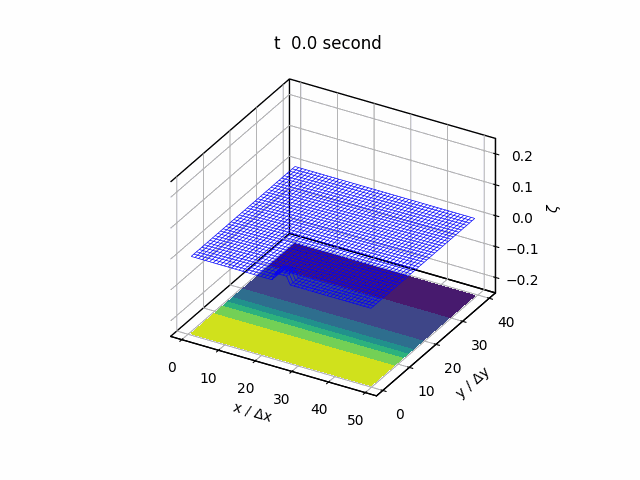

Button(description='tmpx4yg28mx.gif', style=ButtonStyle())

In [ ]:
show_anim(plot_anim, range(len(output['h'])))


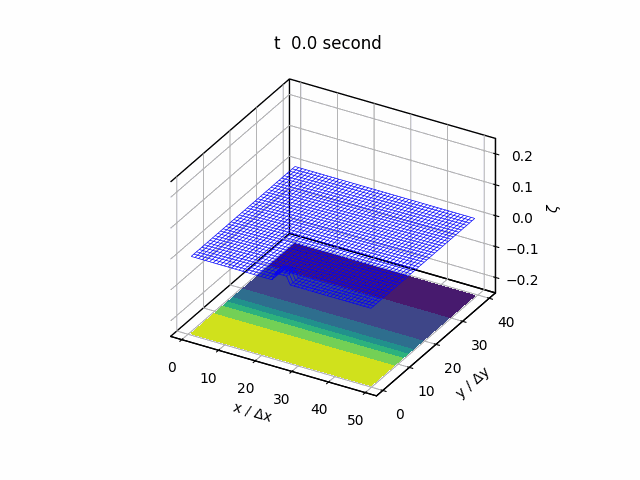

Button(description='tmpn05nql88.gif', style=ButtonStyle())

In [ ]:
show_anim(plot_anim, range(len(output['h'])))

### Uwagi:
W trakcie symulacji można zaobserwować odbicie od brzegów domeny dla małych wartości Y, jednak w przypadku tej symulacji nie wpływa to na wyniki (badana jest jedynie część na wypłaszczeniu), zatem zostało to pozostawione jako część symulacji.

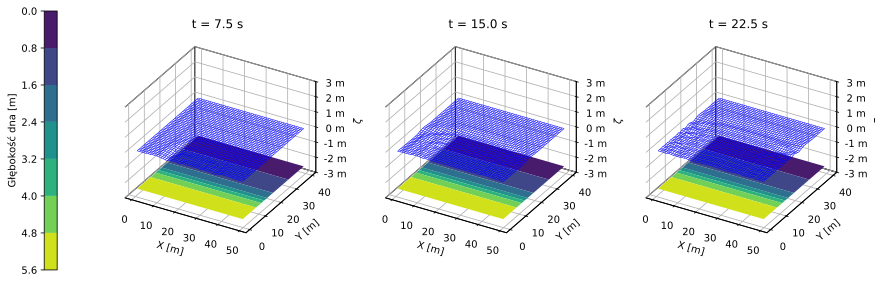

In [ ]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

for idx, frame in enumerate([ 10, 20, 30]):
    _, contour = plot(frame, output, outfreq,dt,dx,dy ,ax=axes[idx])

# plt.tight_layout()
cbar_ax = fig.add_axes([0.05, 0.2, 0.015, 0.6])
cbar = fig.colorbar(contour, cax=cbar_ax,
                   ax=axes,
                   pad=0.02,
                   aspect=15,
                   shrink=0.8,
                   label='Głębokość dna [m]',
                   location='left')


cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x*10:.1f}'))
cbar.ax.invert_yaxis()
plt.subplots_adjust( right=0.98)


Można zaobserwować, że fale rozchodzą się szybko i z dużą amplitudą w kierunku osi X. W kierunku osi Y w momencie trafienia na schodek fale gwałtownie tracą amplitudę. Można to zaobserwować również na wykresie przekroju.

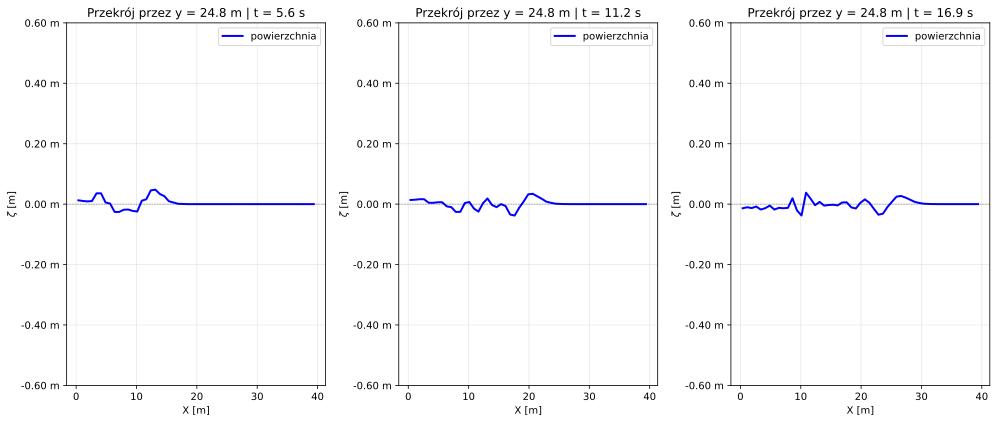

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
for idx, frame in enumerate([10, 20, 30]):
    plt.sca(axes[idx])
    plot_section(frame, output, outfreq,dt,dx, ax=axes[idx], label = "powierzchnia")
plt.tight_layout()


W celu stwierdzenia zbieżności modelu wywołam ta samą symulację dla różnych rozdzielczości czasowych i przestrzennych.

3
(66, 53)


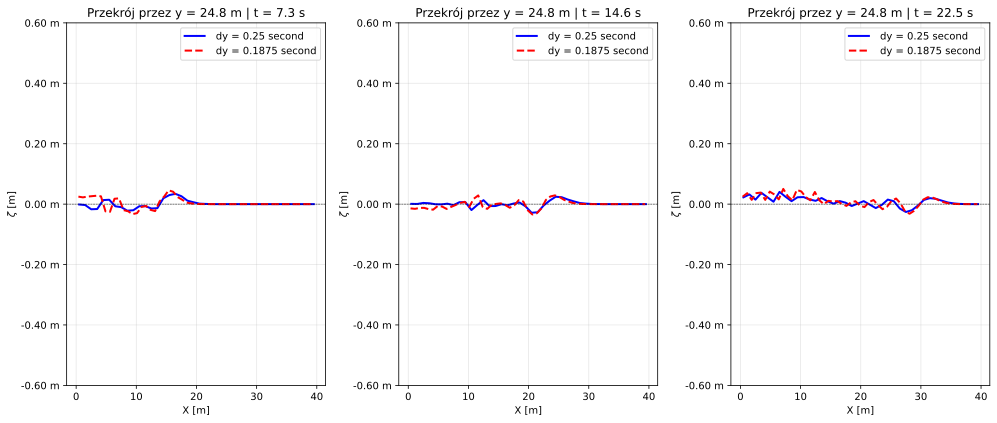

In [ ]:
X = 50*si.m
Y = 40*si.m
time  = 25*si.s
outfreq = 3
dx = 1*si.m
dy = 1*si.m
dt = 0.25*si.s
nt=int((time/dt).to_base_units().magnitude)
dt_dx = (dt/dx).to_base_units().magnitude
dt_dy = (dt/dy).to_base_units().magnitude
output, outfreq, bathymetry = solve(bottom=5*si.m, plateau=2*si.m, )
print(len(output))

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
for idx, frame in enumerate([10, 20, 30]):
    plt.sca(axes[idx])
    plot_section(frame, output, outfreq,dt,dx, ax=axes[idx], label = f" dy = {dt}")
plt.tight_layout()
dx = 0.75*si.m
dy = 0.75*si.m
dt = 0.25*3/4*si.s
nt=int((time/dt).to_base_units().magnitude)
dt_dx = (dt/dx).to_base_units().magnitude
dt_dy = (dt/dy).to_base_units().magnitude
grid = (int(X/dx), int(Y/dy))
print(grid)
output, outfreq, bathymetry = solve(bottom=5*si.m, plateau=2*si.m,grid = grid, dt_dxy=(dt_dx, dt_dy), nt=nt)#trzeba zmienic outfreq
for idx, frame in enumerate([int(10*4/3), int(20*4/3),int(30*4/3)]):
    plt.sca(axes[idx])
    plot_section(frame, output, outfreq,dt,dx, ax=axes[idx], label=f" dy = {dt}", color="red", lin="dashed")
plt.tight_layout()
#
# show_anim(lambda f: plot(f, output, outfreq), range(len(output['h']
plt.tight_layout()

(100, 80)
(66, 53)
(50, 40)
(40, 32)


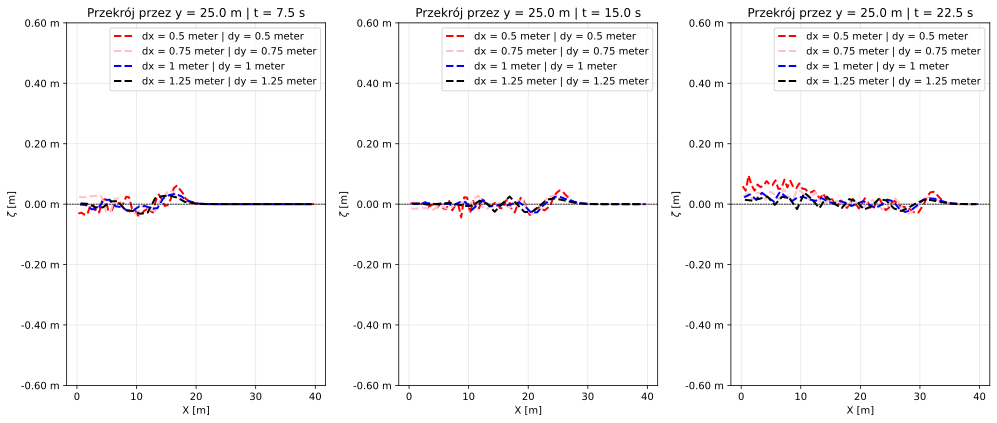

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
colors = {0.75*si.m:"pink",0.5*si.m:"red", 1*si.m:"blue",  1.25*si.m:"black"}

for dx in [0.5*si.m,0.75*si.m, 1*si.m,1.25*si.m]:
  outfreq = 1
  dx = dx
  dy = dx
  dt = 0.25*dx.magnitude*si.s
  nt=int((time/dt).to_base_units().magnitude)
  dt_dx = (dt/dx).to_base_units().magnitude
  dt_dy = (dt/dy).to_base_units().magnitude
  grid = (int(X/dx), int(Y/dy))
  print(grid)
  output, outfreq, bathymetry = solve(bottom=5*si.m, plateau=2*si.m,grid = grid, dt_dxy=(dt_dx, dt_dy), nt=nt)#trzeba zmienic outfreq
  for idx, frame in enumerate([int(10/dx.magnitude), int(20/dx.magnitude), int(30/dx.magnitude)]):
      plt.sca(axes[idx])
      plot_section(frame, output, outfreq,dt,dx, ax=axes[idx], label=f"dx = {dx} | dy = {dy}", color=colors[dx], lin="dashed")
  plt.tight_layout()

  plt.tight_layout()

Jak można zauważyć model dla pierwszej fali jest  stabilny w zakresie kroku przestrzennego [0.75m;1.25m] i dla odpowiadających im kroków czasowych. W dalszej części modelu występują trudne do przewidzenia intereferencje z falami odbitymi od granicy domeny obliczeniowej.

Obserwacje potwierdzają, że fala gwałtownie zmniejsza amplitudę i się rozszerza w momencie trafienia na wypłaszczenie. Podobną analizę przeprowadzę dla prędkości.  

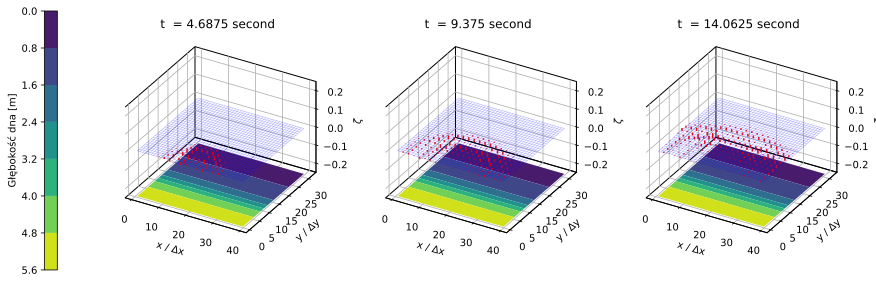

In [ ]:
X = 80*si.m
Y = 40*si.m
time  = 25*si.s
outfreq = 3
dx = 1*si.m
dy = 1*si.m
dt = 0.25*si.s
nt=int((time/dt).to_base_units().magnitude)
dt_dx = (dt/dx).to_base_units().magnitude
dt_dy = (dt/dy).to_base_units().magnitude
grid = (int(X/dx), int(Y/dy))
output, outfreq, bathymetry = solve(bottom=5*si.m, plateau=2*si.m,grid = grid, dt_dxy=(dt_dx,dt_dy), nt=nt )

fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

for idx, frame in enumerate([5, 10, 15]):
    _, contour = plot_velocity_field(frame, output, outfreq,dt,dx,dy ax=axes[idx])

# plt.tight_layout()
cbar_ax = fig.add_axes([0.05, 0.2, 0.015, 0.6])
cbar = fig.colorbar(contour, cax=cbar_ax,
                   ax=axes,
                   pad=0.02,
                   aspect=15,
                   shrink=0.8,
                   label='Głębokość dna [m]',
                   location='left')


cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x*10:.1f}'))
cbar.ax.invert_yaxis()
plt.subplots_adjust( right=0.98)
plt.subplots_adjust( right=0.98)


Wektory prędkości są dłuższe również w miejscu głebszego dna, przy wejściu na wypłaszczenie gwałtownie zmniejszają swoją wielkość co oznacza, że fale zwalniają.

Otrzymane wykresy mają tą samą strukturę, co zaobserwowane wcześniej dla innej rozdzielczości. Te wykresy tak samo charateryzują się gwałtownym zmniejszeniem wychylenia przy napotkaniu płycizny w wodzie. Można zatem stwierdzić, że model jest zbieżny dla różnych parametrów siatki i kroku czasowego.

## Symulacje związane z maksymalną głebokością dna
Przeprowadzono symulacje dla wybranych głękokości dna (*bottom_level*) z zakresu od 7m do 3m. Otrzymane maksymalne wysokości i prędkości wyrysowano na wykresach. Wysokośc fal brano pod uwagę w strefie przybrzeżnej dla indeksów siatki na osi Y od 25 do 40.

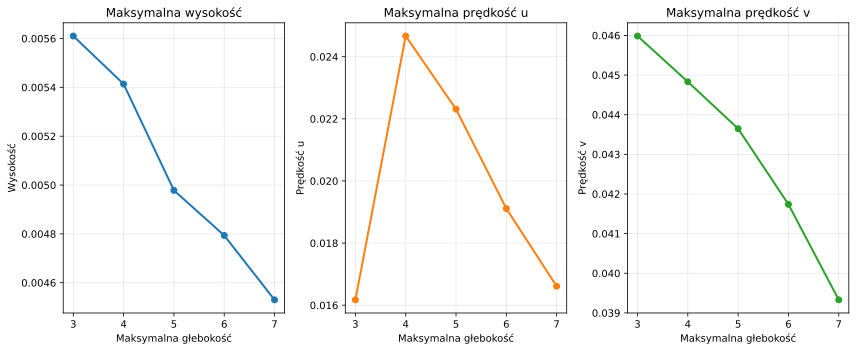

In [ ]:
heights = []
vs=[]
us=[]
bottoms = [7, 6, 5, 4, 3]
for bottom in bottoms:
  output, outfreq, bathymetry = solve(bottom=bottom*si.m, plateau=2*si.m)
  max_height = find_max_height(output, 25, 40)
  max_v, max_u = find_max_velocity(output, 25, 40)
  heights.append(max_height*10)
  vs.append(max_v*dx.magnitude/dt.magnitude)
  us.append(max_u*dy.magnitude/dt.magnitude)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].plot(bottoms, heights, 'o-', linewidth=2)
axes[0].set(xlabel='Maksymalna głebokość[m]', ylabel='Wysokość [m]', title='Maksymalna wysokość')
axes[0].grid(True, alpha=0.3)

axes[1].plot(bottoms, us, 'o-', linewidth=2, color='C1')
axes[1].set(xlabel='Maksymalna głebokość[m]', ylabel='Prędkość u [m/s]', title='Maksymalna prędkość u')
axes[1].grid(True, alpha=0.3)

axes[2].plot(bottoms, vs, 'o-', linewidth=2, color='C2')
axes[2].set(xlabel='Maksymalna głebokość[m]', ylabel='Prędkość v [m/s]', title='Maksymalna prędkość v')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()


Wyniki na wykresach wskazują, że zmiana maksymalnej głebokości akwenu  wpływa na wysokość zarejestrowanych fal oraz ich prędkość. Im płytsza początkowa głebokość, z której rozchodzi się zaburzenie tym z większą prędkośćią się rozchodzi na płyciźnie. W każdym z trzech wykresów obserwowany przyrost jest liniowy. Prawdopodobne wytłumaczenie dla tego fenomenu może być związana z wysokością "schodka". Wskazuje to, że im większy schodek tym bardziej spowalnia on i zmniejsza rejestrowane fale.

## Symulacje związane z położeniem granicy między płycizną, a spadkiem
Podobne symulacje przeprowadzono dla ustalonej maksymalnej głebokości akwenu równej 0.5 i z zmiennym położeniem granicy między płycizną, a "schodkiem". Wartość *plateau_level* zmienia się w przedziale [0.7, 0.9].

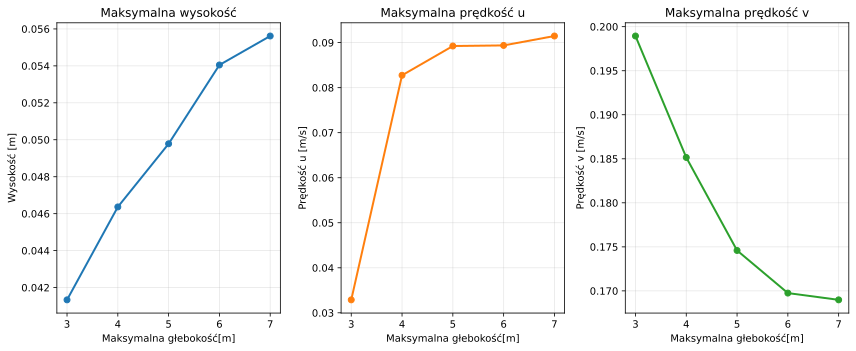

In [ ]:
heights = []
vs=[]
us=[]
plateaus = [3, 2.5, 2,1.5, 1]
for plateau in plateaus:
  output, outfreq, bathymetry = solve(bottom=5*si.m, plateau=plateau*si.m)
  max_height = find_max_height(output, 25, 40)
  max_v, max_u = find_max_velocity(output, 25, 40)
  heights.append(max_height*10)
  vs.append(max_v*dx.magnitude/dt.magnitude)
  us.append(max_u*dy.magnitude/dt.magnitude)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].plot(bottoms, heights, 'o-', linewidth=2)
axes[0].set(xlabel='Maksymalna głebokość[m]', ylabel='Wysokość [m]', title='Maksymalna wysokość')
axes[0].grid(True, alpha=0.3)

axes[1].plot(bottoms, us, 'o-', linewidth=2, color='C1')
axes[1].set(xlabel='Maksymalna głebokość[m]', ylabel='Prędkość u [m/s]', title='Maksymalna prędkość u')
axes[1].grid(True, alpha=0.3)

axes[2].plot(bottoms, vs, 'o-', linewidth=2, color='C2')
axes[2].set(xlabel='Maksymalna głebokość[m]', ylabel='Prędkość v [m/s]', title='Maksymalna prędkość v')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()


Wyniki dla tych symulacji znacznie trudniej zinterpretować. Można stwierdzić, że wzrost poziomu na jakim znajduje się płycizna sprawia, że zarówno wysokość fal jak i prędkości maleją. Spadek dla prędkości v odbywającej się  w kierunku osi Y  jest w przybliżeniu liniowy, co potwierdza, że wysokość "schodka" i współrzędna płycizny wpływa hamująco na fale poruszające się do brzegu. Podobne stwierdzenie można podstawić w przypadku prędkości w kierunku osi X, występuje jedynie anomalia w postaci wzrostu prędkośc względem poprzeniej dla *plateau_level = 0.85*. Dla wysokości fal widać wyraźny spadek dla biorąd pod uwage początek i koniec wykresu, jednak wyniki pomiedzy są trudne do zinterpretowania.

## Podsumowanie
Zastosowany solver pozwala zasymulować zachowanie wody nawet przy dość nieregularnym kształcie dna. Metoda jest stabilna dla zwiększania rozdzielczości czasowej i przestrzennej. Zaobserwowane efekty sugerują, że wysokość spadku w powierzchni dna ma duży wpływ na obserowane fale. Im większy jest "schodek" tym przy brzegu fale są mniejsze i wolniejsze. Oznacza to, że przedłużanie plaż ma destruktywny wpływ na zmierzające w stronę brzegu fale, co może wpływać korzystnie na bezpieczeństwo osób się tam znajdujących.